# Plotting cross-sections

This Notebook takes the receiver output files of a SeisSol simulation and can plot the particle velocity along the trace given by the receivers as well as generate a distance-time figure.

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from cmcrameri import cm

import seissolxdmf 
import pyproj
import matplotlib.tri as tri
import matplotlib
from mpl_toolkits.basemap import Basemap, maskoceans
from netCDF4 import Dataset

from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#plt.rcParams["font.family"] = "serif"
#plt.rc('xtick', labelsize=12) 
#plt.rc('ytick', labelsize=12)

In [118]:
plt.rcParams["font.family"] = "sans-serif"
ps = 12
plt.rcParams.update({"font.size": ps})
plt.rcParams["font.family"] = "sans"
matplotlib.rc("xtick", labelsize=ps)
matplotlib.rc("ytick", labelsize=ps)

In [119]:
label = "West"

if (label == "West"):
    directory = "/import/freenas-m-04-students/fkutschera/simulations/HFFZ_fullycp_o5_180s_west/"
    xdmfFilename = "HFFZ_fu-surface.xdmf"
    receivers = "HFFZ_fu-receiver*.dat"
    hypo_lon = -18.6257
    hypo_lat = 66.3158
elif (label == "Middle"):
    directory = "/import/freenas-m-04-students/fkutschera/simulations/HFFZ_fullycp_o5_180s_middle/"
    xdmfFilename = "HFFZ_-surface.xdmf"
    receivers = "HFFZ_-receiver*.dat"
    hypo_lon = -17.9044
    hypo_lat = 66.1515
elif (label == "East"):
    directory = "/import/freenas-m-04-students/fkutschera/simulations/HFFZ_fullycp_o5_180s_east/"
    xdmfFilename = "HFFZ_full-surface.xdmf"
    hypo_lon = -17.2286
    hypo_lat = 66.0201
    receivers = "HFFZ_full-receiver*.dat"
else:
    print("ERROR")

In [120]:
column_names = ["Time","xx","yy","zz","xy","yz","xz","v1","v2","v3"]
transformer = pyproj.Transformer.from_crs("utm27", "epsg:4326", always_xy=True)

## SeisSolxdmf

In [121]:
def plot_ssha(ax,xdmfFilename,timestep,barcolor):
    x1, x2, y1, y2 = -19.0, -16.8, 65.9, 66.4 #Iceland
    m = Basemap(epsg=4326, ax=ax, resolution="c", llcrnrlon=x1, urcrnrlon=x2, llcrnrlat=y1, urcrnrlat=y2)
    bathy = "/import/freenas-m-05-seissol/kutschera/HIWI/Scripts/Github/GMT/Iceland/input/GEBCO_08_Dec_2021_074bdff0ecf9/gebco_2021_n68.0_s62.0_w-25.0_e-12.0.nc"
    fh = Dataset(bathy, mode="r")
    y = fh.variables["lat"][:]
    x = fh.variables["lon"][:]
    z = fh.variables["elevation"][:, :]
    fh.close()
    idx = np.where((x > x1) & (x < x2))[0]
    idy = np.where((y > y1) & (y < y2))[0]
    x = x[idx]
    y = y[idy]
    z = z[idy, :]
    z = z[:, idx]
    lon, lat = np.meshgrid(x, y)
    X, Y = m(lon, lat)
    # Coast line
    ax.contour(X, Y, z, levels=[0], colors="k")

    sx = seissolxdmf.seissolxdmf(xdmfFilename) # initiate class
    dt = sx.ReadTimeStep()
    xyz = sx.ReadGeometry() # load geometry array as a numpy array of shape
    connect = sx.ReadConnect() # load connectivity array as a numpy array of shape
    U = sx.ReadData("u3", timestep)    
    print("Maximum ssha = {}".format(max(U)))
    XYZcenters0 = (xyz[connect[:, 0], :] + xyz[connect[:, 1], :] + xyz[connect[:, 2], :]) / 3.0
    Zcenters0 = abs(XYZcenters0[:, 2])
    U = U[Zcenters0 < 0.001]
    connect = connect[Zcenters0 < 0.001]
    
    lon, lat = transformer.transform(xyz[:,0], xyz[:,1])
    x, y = m(lon,lat)
    im = ax.tripcolor(x, y, connect, facecolors=U, cmap=cm.cork, rasterized=True, vmin=-0.6, vmax=0.6)
    x1, x2, y1, y2 = -19.0, -16.8, 65.9, 66.4 #Iceland
    ax.set_xlim(x1,x2)
    ax.set_xticks(np.arange(x1,x2, step=0.5))
    ax.set_title("t = {} s".format(timestep*dt))
    ax.set_ylim(y1,y2)
    
    if barcolor==True:
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        cbaxes = inset_axes(ax, width="3%", height="50%", loc='lower right')
        cbar = plt.colorbar(im, cax=cbaxes, extend="both", ticks=[-0.6,-0.3,0.0,0.3,0.6])
        cbaxes.yaxis.set_ticks_position("left")
        cbar.set_label("ssha [m]", rotation=270, labelpad=20)

In [122]:
def plot_ssvv(ax,xdmfFilename,timestep,barcolor):
    x1, x2, y1, y2 = -19.0, -16.8, 65.9, 66.4 #Iceland
    m = Basemap(epsg=4326, ax=ax, resolution="c", llcrnrlon=x1, urcrnrlon=x2, llcrnrlat=y1, urcrnrlat=y2)
    bathy = "/import/freenas-m-05-seissol/kutschera/HIWI/Scripts/Github/GMT/Iceland/input/GEBCO_08_Dec_2021_074bdff0ecf9/gebco_2021_n68.0_s62.0_w-25.0_e-12.0.nc"
    fh = Dataset(bathy, mode="r")
    y = fh.variables["lat"][:]
    x = fh.variables["lon"][:]
    z = fh.variables["elevation"][:, :]
    fh.close()
    idx = np.where((x > x1) & (x < x2))[0]
    idy = np.where((y > y1) & (y < y2))[0]
    x = x[idx]
    y = y[idy]
    z = z[idy, :]
    z = z[:, idx]
    lon, lat = np.meshgrid(x, y)
    X, Y = m(lon, lat)
    # Coast line
    ax.contour(X, Y, z, levels=[0], colors="k")

    sx = seissolxdmf.seissolxdmf(xdmfFilename) # initiate class
    dt = sx.ReadTimeStep()
    xyz = sx.ReadGeometry() # load geometry array as a numpy array of shape
    connect = sx.ReadConnect() # load connectivity array as a numpy array of shape
    U = sx.ReadData("v3", timestep)
    print("Maximum ssvv = {}".format(max(U)))
    XYZcenters0 = (xyz[connect[:, 0], :] + xyz[connect[:, 1], :] + xyz[connect[:, 2], :]) / 3.0
    Zcenters0 = abs(XYZcenters0[:, 2])
    U = U[Zcenters0 < 0.001]
    connect = connect[Zcenters0 < 0.001]
    
    lon, lat = transformer.transform(xyz[:,0], xyz[:,1])
    x, y = m(lon,lat)
    im = ax.tripcolor(x, y, connect, facecolors=U, cmap="viridis", rasterized=True, vmin=-0.4, vmax=0.4)
    x1, x2, y1, y2 = -19.0, -16.8, 65.9, 66.4 #Iceland
    ax.set_xlim(x1,x2)
    ax.set_xticks(np.arange(x1,x2, step=0.5))
    #ax.set_title("t = {} s".format(timestep*dt))
    ax.set_ylim(y1,y2)
    
    if barcolor==True:
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        cbaxes = inset_axes(ax, width="3%", height="50%", loc='lower right')
        cbar = plt.colorbar(im, cax=cbaxes, extend="both", ticks=[-0.4,-0.2,0.0,0.2,0.4])#ticks=[-0.6,-0.3,0.0,0.3,0.6])
        cbaxes.yaxis.set_ticks_position("left")
        cbar.set_label("ssvv [m]", rotation=270, labelpad=20)

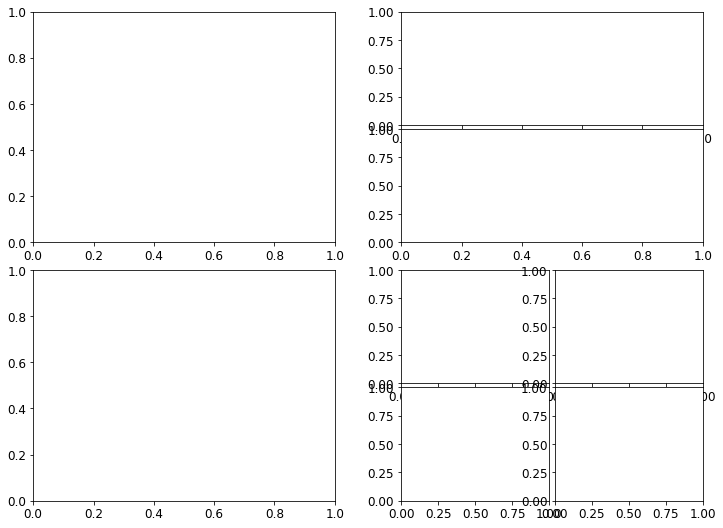

In [123]:
fig = plt.figure(figsize=(12,9))

gs = gridspec.GridSpec(21,22)
ax1 = fig.add_subplot(gs[0:10,0:10])
#plot_ssha(ax1,directory+xdmfFilename,20,True)

ax2 = fig.add_subplot(gs[0:5,12:22])
ax3 = fig.add_subplot(gs[5:10,12:22])

ax4 = fig.add_subplot(gs[11:21,0:10])
#plot_ssvv(ax4,xdmfFilename,20,True)

ax5 = fig.add_subplot(gs[11:16,12:17])
ax6 = fig.add_subplot(gs[11:16,17:22])
ax7 = fig.add_subplot(gs[16:21,12:17])
ax8 = fig.add_subplot(gs[16:21,17:22])


#ax5 = fig.add_subplot(gs[13:19,11:16])
#ax6 = fig.add_subplot(gs[13:19,17:22])

## Distance-Time stack 

In [124]:
#files = glob.glob(os.path.join(directory, "HFFZ_full-receiver*.dat"))
files = glob.glob(os.path.join(directory, receivers))

In [125]:
# NO NEED TO EXECUTE AGAIN WHEN .csv EXISTS
if (os.path.isfile(directory+"{}-trace1.csv".format(label)) and os.path.isfile(directory+"{}-trace2.csv".format(label))):
    print ("Files exist")
    # read output
    trace1 = pd.read_csv(directory+"{}-trace1.csv".format(label))
    trace2 = pd.read_csv(directory+"{}-trace2.csv".format(label))
else:
    print ("Files do not exist - creating them")
    
    for f in files:
        frame = pd.read_csv(f, skiprows=5, sep='\s+', names=column_names)
        frame.drop(columns=["xx","yy","zz","xy","yz","xz"], inplace=True)
        coords = pd.read_csv(f, nrows=3, skiprows=2, header=None, sep="\s+")
        x1 = coords[2][0]
        x2 = coords[2][1]
        x3 = coords[2][2]
        frame["x1"]=x1
        frame["x2"]=x2
        frame["x3"]=x3
        if (files[0]==f):
            total_stack = frame
        else:
            total_stack = pd.concat([total_stack, frame])
            
    # sort first by coorindates and then by Time for separation
    total_stack.sort_values(['x1','Time'], inplace=True)     
    
    # split total dataframe in the 2 traces
    split = int(len(total_stack)/2)
    print(split)
    trace1 = total_stack.iloc[:split,:]
    trace2 = total_stack.iloc[split:,:]
    print("Shape of new dataframes - {} , {}".format(trace1.shape, trace2.shape))
    
    # sort now first by Time and then by coorindates
    trace1.sort_values(['Time', 'x1'], inplace=True)
    trace2.sort_values(['Time', 'x1'], inplace=True)
    
    trace1.to_csv(directory+"{}-trace1.csv".format(label), index=False)
    trace2.to_csv(directory+"{}-trace2.csv".format(label), index=False)
    print("Done.")

Files exist


In [126]:
trace1.head()

,Time,v1,v2,v3,x1,x2,x3
0,0.0,0.0,0.0,0.0,612800.0,7327000.0,-0.1
1,0.0,0.0,0.0,0.0,612822.2,7327038.0,-0.1
2,0.0,0.0,0.0,0.0,612844.4,7327076.0,-0.1
3,0.0,0.0,0.0,0.0,612866.6,7327114.0,-0.1
4,0.0,0.0,0.0,0.0,612888.8,7327152.0,-0.1


In [127]:
trace1_min_x1 = min(trace1.x1)
trace1_min_x2 = min(trace1.x2)
trace1_max_x1 = max(trace1.x1)
trace1_max_x2 = max(trace1.x2)

trace2_min_x1 = min(trace2.x1)
trace2_min_x2 = min(trace2.x2)
trace2_max_x1 = max(trace2.x1)
trace2_max_x2 = max(trace2.x2)

print("Trace 1: Min x1 = {}, Min x2 = {}, Max x1 = {}, Max x2 = {}".format(
    trace1_min_x1, trace1_min_x2, trace1_max_x1, trace1_max_x2))
print("Trace 2: Min x1 = {}, Min x2 = {}, Max x1 = {}, Max x2 = {}".format(
    trace2_min_x1, trace2_min_x2, trace2_max_x1, trace2_max_x2))

trace1_min_lon, trace1_min_lat = transformer.transform(trace1_min_x1, trace1_min_x2)
trace1_max_lon, trace1_max_lat = transformer.transform(trace1_max_x1, trace1_max_x2)
trace2_min_lon, trace2_min_lat = transformer.transform(trace2_min_x1, trace2_min_x2)
trace2_max_lon, trace2_max_lat = transformer.transform(trace2_max_x1, trace2_max_x2)

print("Trace 1: Min lon = {:.3f}, Min lat = {:.3f}, Max lon = {:.3f}, Max lat = {:.3f}".format(
    trace1_min_lon, trace1_min_lat, trace1_max_lon, trace1_max_lat))
print("Trace 2: Min lon = {:.3f}, Min lat = {:.3f}, Max lon = {:.3f}, Max lat = {:.3f}".format(
    trace2_min_lon, trace2_min_lat, trace2_max_lon, trace2_max_lat))

Trace 1: Min x1 = 612800.0, Min x2 = 7327000.0, Max x1 = 635000.0, Max x2 = 7365000.0
Trace 2: Min x1 = 650000.0, Min x2 = 7329000.0, Max x1 = 671000.0, Max x2 = 7365000.0
Trace 1: Min lon = -18.510, Min lat = 66.042, Max lon = -17.980, Max lat = 66.373
Trace 2: Min lon = -17.688, Min lat = 66.044, Max lon = -17.177, Max lat = 66.356


In [128]:
# need to adjust time due to floating point errors/ rounding
time_length = 1800
time_array = np.linspace(0, 179.9, time_length)

In [129]:
length_trace1 = np.sqrt((trace1['x1'].iloc[0] - trace1['x1'].iloc[-1])**2 + (trace1['x2'].iloc[0] - trace1['x2'].iloc[-1])**2)
length_trace1 = length_trace1/1000 # km

length_trace2 = np.sqrt((trace2['x1'].iloc[0] - trace2['x1'].iloc[-1])**2 + (trace2['x2'].iloc[0] - trace2['x2'].iloc[-1])**2)
length_trace2 = length_trace2/1000 # km
print("Length trace 1 = {} and trace 2 = {}".format(length_trace1, length_trace2))

Length trace 1 = 44.0095444193643 and trace 2 = 41.677331968349414


In [130]:
# Create distance array for plotting
distance_trace1 = np.linspace(0,length_trace1,int(len(files)/2))

distance_trace2 = np.linspace(0,length_trace2,int(len(files)/2))

if not (len(distance_trace1) == len(distance_trace2)):
    print("ERROR")

In [131]:
# not needed
#DISTANCE_trace1, TIME = np.meshgrid(distance_trace1, time_array)
#DISTANCE_trace2, TIME = np.meshgrid(distance_trace2, time_array)

In [132]:
SSVV_trace1 = trace1["v3"].values.reshape(-1, len(distance_trace1))  # same as above: a1.reshape(3, 4)
SSVV_trace2 = trace2["v3"].values.reshape(-1, len(distance_trace2))
if not (SSVV_trace1.shape == SSVV_trace2.shape):
    print("ERROR")
else:
    print(SSVV_trace1.shape)

(1800, 1001)


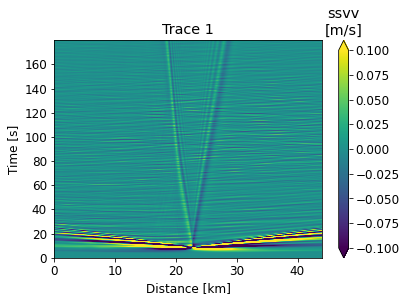

In [133]:
cmap = matplotlib.cm.get_cmap("viridis").copy()
plt.imshow(SSVV_trace1, extent=[distance_trace1[0], distance_trace1[-1], time_array[0], time_array[-1]], 
           origin='lower', aspect='auto', vmin=-0.1, vmax=0.1, cmap=cmap)
clb = plt.colorbar(extend="both")
plt.xlabel("Distance [km]")
plt.ylabel("Time [s]")
plt.title("Trace 1")
clb.ax.set_title("ssvv\n[m/s]")
plt.show()

## Bathymetry

In [134]:
bathy_trace1 = pd.read_csv("/import/freenas-m-05-seissol/kutschera/HIWI/Scripts/Github/GMT/Iceland/BathymetryProfiles/bathy_profile1.dat", 
                 sep="\t", names=["x1","x2","x3","Bathymetry"])
bathy_trace2 = pd.read_csv("/import/freenas-m-05-seissol/kutschera/HIWI/Scripts/Github/GMT/Iceland/BathymetryProfiles/bathy_profile2.dat", 
                 sep="\t", names=["x1","x2","x3","Bathymetry"])

## Combined plot

Maximum ssha = 0.9723475946428738
Maximum ssvv = 2.591925420060223


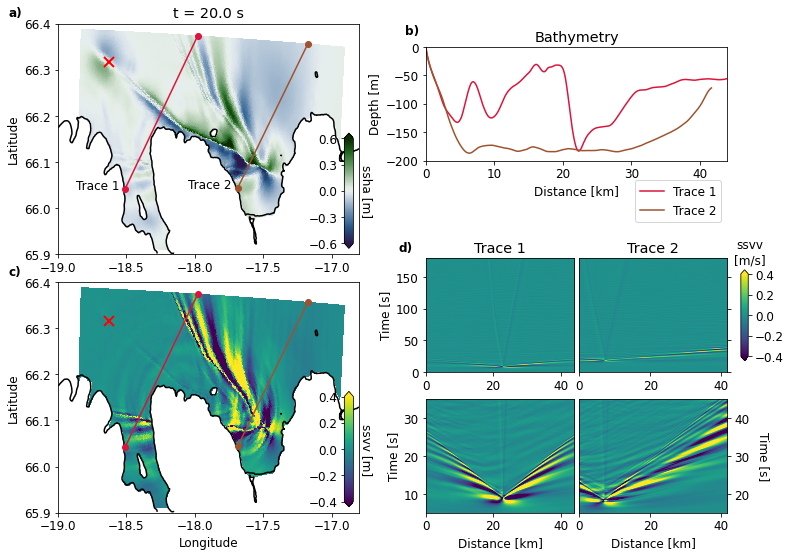

In [135]:
cmap = matplotlib.cm.get_cmap("viridis").copy()
fig = plt.figure(figsize=(12,9))
#fig.suptitle('Scenario {}'.format(label), fontsize=18)
gs = gridspec.GridSpec(21,22)
vmin=-0.4
vmax=0.4

# SSHA
ax1 = fig.add_subplot(gs[0:10,0:10])
plot_ssha(ax1,directory+xdmfFilename,20,True)
ax1.plot([trace1_min_lon, trace1_max_lon], [trace1_min_lat, trace1_max_lat], 'o', color="crimson", linestyle="solid")
ax1.plot([trace2_min_lon, trace2_max_lon], [trace2_min_lat, trace2_max_lat], 'o', color="sienna", linestyle="solid")
ax1.set_ylabel("Latitude")
ax1.text(x=trace1_min_lon-0.36, y=trace1_min_lat, s="Trace 1")
ax1.text(x=trace2_min_lon-0.36, y=trace2_min_lat, s="Trace 2")
ax1.plot(hypo_lon, hypo_lat, 'x', markersize=10, color='red', markeredgewidth=2)

# BATHY 1
ax2 = fig.add_subplot(gs[1:6,12:22])
ax2.plot(distance_trace1,bathy_trace1.Bathymetry, label="Trace 1", color="crimson")
ax2.plot(distance_trace2,bathy_trace2.Bathymetry,label="Trace 2", color="sienna")
ax2.set_xlim(0, max(max(distance_trace1), max(distance_trace2)))
ax2.set_ylim(-200,0)
ax2.set_xlabel("Distance [km]")
ax2.set_ylabel("Depth [m]")
ax2.set_title("Bathymetry")
ax2.legend(loc="upper right", bbox_to_anchor=(1,-0.12))

# SSVV
ax4 = fig.add_subplot(gs[11:21,0:10])
plot_ssvv(ax4,directory+xdmfFilename,20,True)
ax4.plot([trace1_min_lon, trace1_max_lon], [trace1_min_lat, trace1_max_lat], 'o', color="crimson", linestyle="solid")
ax4.plot([trace2_min_lon, trace2_max_lon], [trace2_min_lat, trace2_max_lat], 'o', color="sienna", linestyle="solid")
ax4.set_xlabel("Longitude")
ax4.set_ylabel("Latitude")
ax4.plot(hypo_lon, hypo_lat, 'x', color='red', markersize=10, markeredgewidth=2)

# STACK 1
ax5 = fig.add_subplot(gs[10:15,12:17])
ax5.imshow(SSVV_trace1, extent=[distance_trace1[0], distance_trace1[-1], time_array[0], time_array[-1]], 
           origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)
ax5.set_ylabel("Time [s]")
ax5.set_title("Trace 1")

# STACK 2
ax6 = fig.add_subplot(gs[10:15,17:22])
im = ax6.imshow(SSVV_trace2, extent=[distance_trace2[0], distance_trace2[-1], time_array[0], time_array[-1]], 
           origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)
ax6.set_title("Trace 2")
ax6.yaxis.tick_right()
ax6.axes.yaxis.set_ticklabels([])
cbaxes = inset_axes(parent_axes=ax6, width="5%", height="80%", loc='center left', 
                    bbox_to_anchor=(1.05, 0.0, 1, 1), bbox_transform=ax6.transAxes)
cbar = plt.colorbar(im, cax=cbaxes, ticks=[vmin,vmin/2,0.0,vmax/2,vmax], extend="both")
cbar.ax.set_title("ssvv\n[m/s]", x=1.2, fontsize=12)


# STACK 1 zoom
ax7 = fig.add_subplot(gs[16:21,12:17])
ax7.imshow(SSVV_trace1, extent=[distance_trace1[0], distance_trace1[-1], time_array[0], time_array[-1]], 
           origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)
ax7.set_xlabel("Distance [km]")
ax7.set_ylabel("Time [s]")
if (label == "West"):
    ax7.set_ylim(5,35)
elif (label == "Middle"):
    ax7.set_ylim(5,35)
elif (label == "East"):
    ax7.set_ylim(15,45)

# STACK 2 zoom
ax8 = fig.add_subplot(gs[16:21,17:22])
ax8.imshow(SSVV_trace2, extent=[distance_trace2[0], distance_trace2[-1], time_array[0], time_array[-1]], 
           origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)
ax8.set_xlabel("Distance [km]")
ax8.set_ylabel("Time [s]", rotation=270, labelpad=20)
ax8.yaxis.tick_right()
ax8.yaxis.set_label_position("right")
if (label == "West"):
    ax8.set_ylim(15,45)
elif (label == "Middle"):
    ax8.set_ylim(5,35)
elif (label == "East"):
    ax8.set_ylim(5,35)
    
# Add figure labels
ax1.text(-19.36, 66.415, "a)", fontsize=12, weight="bold")
ax2.text(-3, 22, "b)", fontsize=12, weight="bold")
ax4.text(-19.36, 66.415, "c)", fontsize=12, weight="bold")
ax2.text(-4, -360, "d)", fontsize=12, weight="bold")

fig.savefig("Scenarios_{}_notitle.png".format(label), dpi=300)
plt.show()

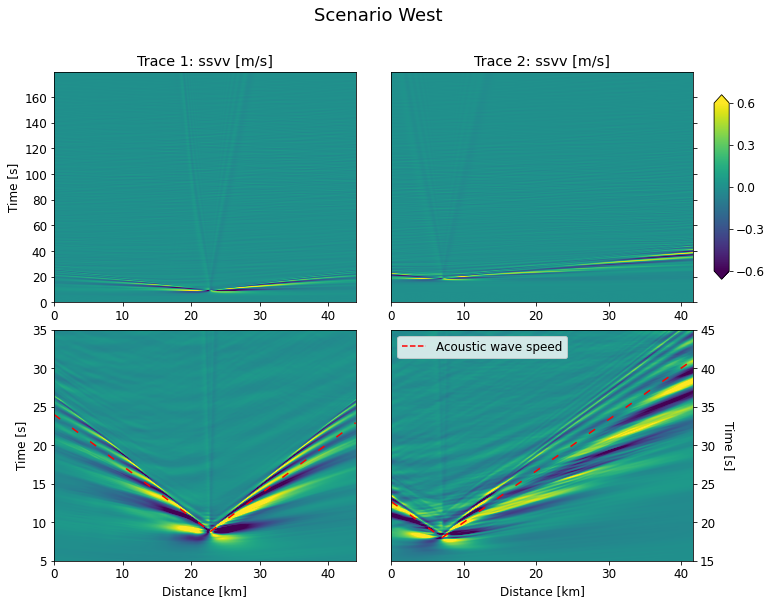

In [136]:
# only SSVV
cmap = matplotlib.cm.get_cmap("viridis").copy()
fig = plt.figure(figsize=(12,9))
fig.suptitle('Scenario {}'.format(label), fontsize=18)
gs = gridspec.GridSpec(21,22)
vmin=-0.6
vmax=0.6
vel_ac = 1.5

# STACK 1
ax5 = fig.add_subplot(gs[0:10,0:10])
ax5.imshow(SSVV_trace1, extent=[distance_trace1[0], distance_trace1[-1], time_array[0], time_array[-1]], 
           origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)
ax5.set_ylabel("Time [s]")
ax5.set_title("Trace 1: ssvv [m/s]")

# STACK 2
ax6 = fig.add_subplot(gs[0:10,11:21])
im = ax6.imshow(SSVV_trace2, extent=[distance_trace2[0], distance_trace2[-1], time_array[0], time_array[-1]], 
           origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)
ax6.set_title("Trace 2: ssvv [m/s]")
ax6.yaxis.tick_right()
ax6.axes.yaxis.set_ticklabels([])
cbaxes = inset_axes(parent_axes=ax6, width="5%", height="80%", loc='center left', 
                    bbox_to_anchor=(1.05, 0.0, 1, 1), bbox_transform=ax6.transAxes)
cbar = plt.colorbar(im, cax=cbaxes, ticks=[vmin,vmin/2,0.0,vmax/2,vmax], extend="both")

# STACK 1 zoom
ax7 = fig.add_subplot(gs[11:21,0:10])
ax7.imshow(SSVV_trace1, extent=[distance_trace1[0], distance_trace1[-1], time_array[0], time_array[-1]], 
           origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)
ax7.set_xlabel("Distance [km]")
ax7.set_ylabel("Time [s]")
if (label == "West"):
    ax7.set_ylim(5,35)
    time_shift = 8.8
    distance_shift = 22.8
    xr = np.linspace(distance_shift, max(distance_trace1), 1000)
    xl = np.linspace(0, distance_shift, 1000)
    yr = 1/vel_ac*xr - 1/vel_ac*xr[0] + time_shift
    yl = -1/vel_ac*xl + 1/vel_ac*xl[-1] + time_shift
    ax7.plot(xr, yr, linestyle=(0, (5, 10)), color='red')
    ax7.plot(xl, yl, linestyle=(0, (5, 10)), color='red') 
elif (label == "Middle"):
    ax7.set_ylim(5,35)
    time_shift = 8.8
    distance_shift = 22.8
    xr = np.linspace(distance_shift, max(distance_trace1), 1000)
    xl = np.linspace(0, distance_shift, 1000)
    yr = 1/vel_ac*xr - 1/vel_ac*xr[0] + time_shift
    yl = -1/vel_ac*xl + 1/vel_ac*xl[-1] + time_shift
    ax7.plot(xr, yr, linestyle=(0, (5, 10)), color='red')
    ax7.plot(xl, yl, linestyle=(0, (5, 10)), color='red') 
elif (label == "East"):
    ax7.set_ylim(15,45)
    time_shift = 17.5
    distance_shift = 22.8
    xr = np.linspace(distance_shift, max(distance_trace1), 1000)
    xl = np.linspace(0, distance_shift, 1000)
    yr = 1/vel_ac*xr - 1/vel_ac*xr[0] + time_shift
    yl = -1/vel_ac*xl + 1/vel_ac*xl[-1] + time_shift
    ax7.plot(xr, yr, linestyle=(0, (5, 10)), color='red')
    ax7.plot(xl, yl, linestyle=(0, (5, 10)), color='red') 

# STACK 2 zoom
ax8 = fig.add_subplot(gs[11:21,11:21])
ax8.imshow(SSVV_trace2, extent=[distance_trace2[0], distance_trace2[-1], time_array[0], time_array[-1]], 
           origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap=cmap)
ax8.set_xlabel("Distance [km]")
ax8.set_ylabel("Time [s]", rotation=270, labelpad=20)
ax8.yaxis.tick_right()
ax8.yaxis.set_label_position("right")
if (label == "West"):
    ax8.set_ylim(15,45)
    time_shift = 18
    distance_shift = 7
    xr = np.linspace(distance_shift, max(distance_trace2), 1000)
    xl = np.linspace(0, distance_shift, 1000)
    yr = 1/vel_ac*xr - 1/vel_ac*xr[0] + time_shift
    yl = -1/vel_ac*xl + 1/vel_ac*xl[-1] + time_shift
    ax8.plot(xr, yr, linestyle=(0, (5, 10)), color='red')
    ax8.plot(xl, yl, linestyle=(0, (5, 10)), color='red') 
elif (label == "Middle"):
    ax8.set_ylim(5,35)
    time_shift = 8
    distance_shift = 7
    xr = np.linspace(distance_shift, max(distance_trace2), 1000)
    xl = np.linspace(0, distance_shift, 1000)
    yr = 1/vel_ac*xr - 1/vel_ac*xr[0] + time_shift
    yl = -1/vel_ac*xl + 1/vel_ac*xl[-1] + time_shift
    ax8.plot(xr, yr, linestyle=(0, (5, 10)), color='red')
    ax8.plot(xl, yl, linestyle=(0, (5, 10)), color='red') 
elif (label == "East"):
    ax8.set_ylim(5,35)
    time_shift = 8
    distance_shift = 7
    xr = np.linspace(distance_shift, max(distance_trace2), 1000)
    xl = np.linspace(0, distance_shift, 1000)
    yr = 1/vel_ac*xr - 1/vel_ac*xr[0] + time_shift
    yl = -1/vel_ac*xl + 1/vel_ac*xl[-1] + time_shift
    ax8.plot(xr, yr, linestyle=(0, (5, 10)), color='red')
    ax8.plot(xl, yl, linestyle=(0, (5, 10)), color='red') 

from matplotlib.lines import Line2D
#https://stackoverflow.com/questions/39500265/how-to-manually-create-a-legend
colors = ['red']
lines = [Line2D([0], [0], color=c, linestyle="dashed") for c in colors]
labels = ["Acoustic wave speed"]
ax8.legend(lines, labels, loc="upper left")

fig.savefig("Scenarios_{}_SSVV.png".format(label), dpi=300)
plt.show()